# Visão dos dados e desafios

## Dicionário das colunas e dos dados:

Dados históricos da Ibovespa (BVSP), retidados do site [https://br.investing.com](https://br.investing.com/indices/bovespa-historical-data), considerando dados diários de cotações em um período entre **27/12/2020 à 22/08/2023**.
> *Data da Consulta: 22/08/2023*


*  **Data**: A data em que a negociação ocorreu.
*  **Abertura**: O preço pelo qual um ativo começou a ser negociado no dia em questão.
*  **Mínimo**: O menor preço atingido pelo ativo durante o dia de negociação.
*  **Máximo**: O preço mais alto atingido pelo ativo durante o dia de negociação.
*  **Volume** (Vol.): A quantidade total de ações (ou contratos) negociados durante o dia. Indica o interesse e a atividade dos investidores.
*  **Variação** (Var%): A diferença entre o preço de fechamento do dia atual e o preço de fechamento do dia anterior, geralmente expressa em porcentagem. Ela mostra a mudança no valor do ativo de um dia para o outro.



## Objetivos:

> Criar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

> Acurácia do modelo acima de 70%

# Início do projeto

## Importação das bases e primeiras análises dos dados

In [ ]:
# importanto as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import date, time, datetime, timedelta

from google.colab import drive # importar módulo do drive e upar base de dados pelo diretório
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
ibovespa_diario = pd.read_csv("drive/My Drive/Pos Tech Base de Dados/Tech Challenge Fase 2/Base de Dados/dados_ibovespa_dez00-ago23.csv", sep=",", parse_dates=[0], index_col="Data",dayfirst=True) # definição da coluna Data como index
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,"3,67M","-0,76%"
2019-12-27,116.534,117.205,117.803,115.995,"3,91M","-0,57%"
2019-12-26,117.203,115.864,117.220,115.673,"3,79M","1,16%"
2019-12-23,115.863,115.119,115.863,114.964,"4,00M","0,64%"
2019-12-20,115.121,115.133,115.171,114.526,"6,89M","-0,01%"


In [ ]:
print("Range de datas:")
print(f"\tData inicial:",ibovespa_diario.index.min())
print(f"\tData final:",ibovespa_diario.index.max())

Range de datas:
	Data inicial: 2000-12-27 00:00:00
	Data final: 2023-08-22 00:00:00


In [ ]:
total = ibovespa_diario.shape[0]
print("Total de dados na base: ", total)

Total de dados na base:  5611


In [ ]:
ibovespa_diario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5611 entries, 2019-12-30 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5611 non-null   float64
 1   Abertura  5611 non-null   float64
 2   Máxima    5611 non-null   float64
 3   Mínima    5611 non-null   float64
 4   Vol.      5610 non-null   object 
 5   Var%      5611 non-null   object 
dtypes: float64(4), object(2)
memory usage: 306.9+ KB


Necessário realizar alguns pré-processamentos nos dados:
<!-- * Colunas "Último","Abertura", "Máxima", "Mínima": Ajustar casa decimal (valor em milhar) e alterar o type para int. -->

* Vol: retirar caracteres "K" e "M" e tratar valores

* Var%: Retirar caracter "%".

## Tratamento e pré-processamento de dados da base

In [ ]:
# cols_int = ["Último","Abertura", "Máxima", "Mínima"]

# for column in cols_int:
#     ibovespa_diario[column] = (ibovespa_diario[column] * 1000).astype(int)
#     # ibovespa_diario[column] = ibovespa_diario[column].astype(int)

# ibovespa_diario.head()

In [ ]:
# função para retirar caracteres não numericos da coluna Volume
def convert_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1000000
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1000
    return vol

ibovespa_diario = ibovespa_diario.replace(",",".", regex = True) # Tudo que é vírgula vira ponto
ibovespa_diario['Var%'] = ibovespa_diario['Var%'].replace("%"," ", regex = True).astype(float) # Tudo que é vírgula vira ponto
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].apply(convert_volume)
ibovespa_diario['Vol.'] = round(ibovespa_diario['Vol.'].astype(float))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000.0,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000.0,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000.0,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000.0,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000.0,-0.01


In [ ]:
ibovespa_diario.dtypes # validação dos tipos de dados

Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.        float64
Var%        float64
dtype: object

> Tratamento das colunas realizada, com exceção da coluna Vol. que ainda está em float. Ao fazer a transformação, ocorreu um erro sinalizando que existe um dado nulo nesta coluna.

### Identificação de dados nulos ou duplicados

In [ ]:
val_duplicated = ibovespa_diario.duplicated().sum()

print("Validação de dados duplicados:")
if val_duplicated > 0:
  print(f"\tExistem valores duplicados na base, é necessário investigar.")
else:
  print(f"\tNão esxistem valores duplicados na base!")

Validação de dados duplicados:
	Não esxistem valores duplicados na base!


In [ ]:
percent_nulos = 100*((ibovespa_diario.isnull().sum())/(len(ibovespa_diario))) # avaliação de dados nulos
print(percent_nulos)

Último      0.000000
Abertura    0.000000
Máxima      0.000000
Mínima      0.000000
Vol.        0.017822
Var%        0.000000
dtype: float64


Existem valores nulos na coluna Vol.

In [ ]:
ibovespa_diario.loc[ibovespa_diario['Vol.'].isnull()]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40.377,40.592,40.592,39.96,NaN,-0.53


In [ ]:
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].fillna(value = 0) # alterando o valor nulo por 0
ibovespa_diario['Vol.'] = ibovespa_diario['Vol.'].astype(int) # transformação do tipo para inteiro
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01


Por fim, criação de uma coluna com o dia da semana para avaliarmos distribuição

In [ ]:
def obter_dia_da_semana(data_index):
    try:
        data = datetime.strptime(data_index, '%d/%m/%Y')
        dias_da_semana = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
        dia_da_semana = dias_da_semana[data.weekday()]
        return dia_da_semana
    except ValueError:
        return "Data inválida"

ibovespa_diario['Dia_da_Semana'] = ibovespa_diario.index.map(lambda x: obter_dia_da_semana(x.strftime('%d/%m/%Y')))
ibovespa_diario.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Dia_da_Semana
Data,,,,,,,
2019-12-30,115.645,116.530,117.086,115.599,3670000,-0.76,Segunda-feira
2019-12-27,116.534,117.205,117.803,115.995,3910000,-0.57,Sexta-feira
2019-12-26,117.203,115.864,117.220,115.673,3790000,1.16,Quinta-feira
2019-12-23,115.863,115.119,115.863,114.964,4000000,0.64,Segunda-feira
2019-12-20,115.121,115.133,115.171,114.526,6890000,-0.01,Sexta-feira


## EDA e primeiras inferências

In [ ]:
ibovespa_diario.describe().round(2)

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5611.00,5611.00,5611.00,5611.00,5.611000e+03,5611.00
mean,58.87,58.85,59.45,58.26,6.689736e+07,0.05
std,31.07,31.07,31.31,30.81,1.170886e+08,1.75
min,8.37,8.40,8.51,8.22,0.000000e+00,-14.78
25%,37.44,37.41,37.98,36.86,3.010000e+06,-0.88
50%,56.44,56.44,56.97,55.90,5.380000e+06,0.07
75%,74.46,74.42,75.14,73.79,9.910000e+07,1.03
max,130.78,130.78,131.19,129.53,9.949600e+08,14.66


**Inferências iniciais:**

* As médias dos preços das ações não tende a oscilar muito, ao longo do tempo, mas tem uma distanciação em relação à mediana.
* No histórico, há uma média de variação positiva entre os dias.

In [ ]:
ibovespa_diario.groupby("Dia_da_Semana")["Último"].describe().round(2).T # avaliação das estatísticas por dia da semana

Dia_da_Semana,Quarta-feira,Quinta-feira,Segunda-feira,Sexta-feira,Terça-feira
count,1142.00,1122.00,1119.00,1110.00,1118.00
mean,58.92,59.01,58.80,58.78,58.84
std,31.03,31.18,31.13,31.09,30.98
min,8.37,8.87,8.45,8.72,8.51
25%,37.70,37.50,37.24,37.34,37.41
50%,56.46,56.79,56.49,56.49,56.24
75%,74.78,74.68,74.32,73.80,74.32
max,129.91,130.08,130.78,130.13,130.09


A média do preço de fechamento ao longo dos dias se mantem dentro da base.

In [ ]:
ibovespa_diario.groupby("Dia_da_Semana")["Var%"].describe().round(2).T # avaliação das estatísticas por dia da semana

Dia_da_Semana,Quarta-feira,Quinta-feira,Segunda-feira,Sexta-feira,Terça-feira
count,1142.00,1122.00,1119.00,1110.00,1118.00
mean,0.12,0.03,-0.06,0.06,0.11
std,1.72,1.77,1.93,1.60,1.69
min,-11.39,-14.78,-13.92,-6.91,-9.18
25%,-0.84,-0.91,-1.01,-0.80,-0.86
50%,0.12,0.08,-0.01,0.09,0.10
75%,1.20,1.02,0.95,1.00,1.08
max,7.61,7.47,14.66,13.91,13.42


In [ ]:
dados_dia = ibovespa_diario.groupby("Dia_da_Semana")["Último"].nunique()
dados_dia.sort_values(ascending=True, inplace=True)
dados_dia

Dia_da_Semana
Sexta-feira      1103
Segunda-feira    1111
Terça-feira      1111
Quinta-feira     1119
Quarta-feira     1139
Name: Último, dtype: int64

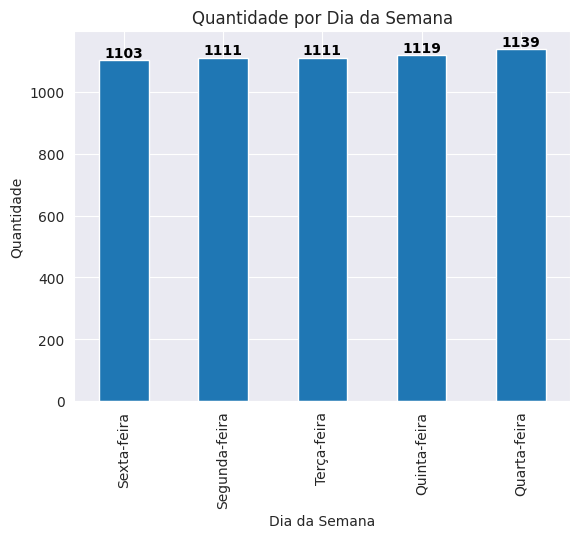

In [ ]:
# Criar o gráfico de barras
ax = dados_dia.plot(kind='bar')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Quantidade por Dia da Semana')

# Adicionar valores como anotações nas barras
for idx, value in enumerate(dados_dia):
    ax.text(idx, value + 10, str(value), ha='center', color='black', fontweight='bold')

plt.show()

## Avaliação das Distribuições

Visão considerando toda série histórica (2000 a 2023)

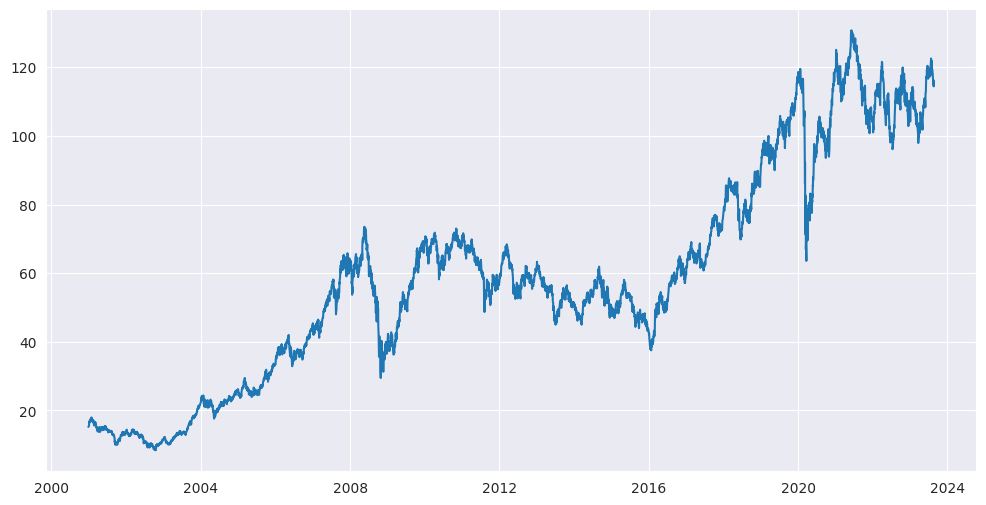

In [ ]:
sns.set_style("darkgrid")
ibovespa_diario = ibovespa_diario.sort_index()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_diario.index, ibovespa_diario.Último)
plt.show()

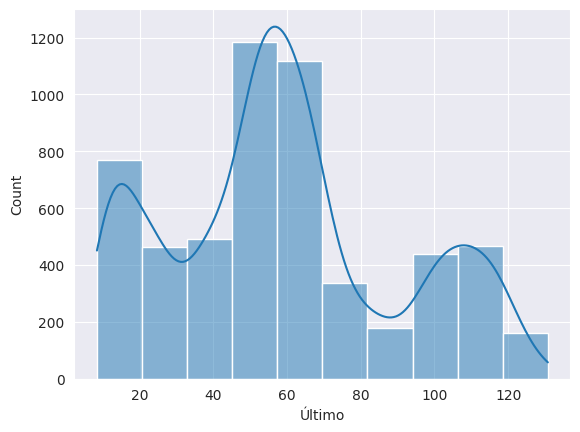

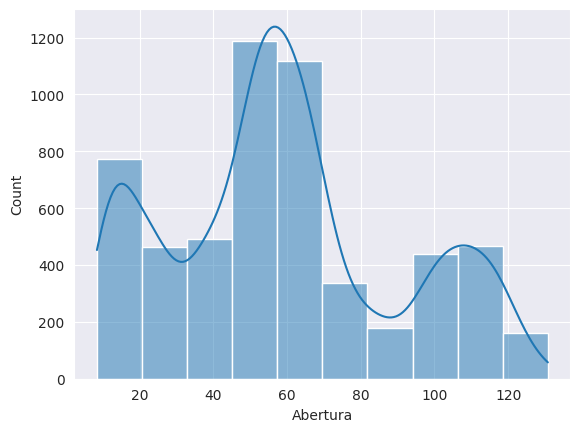

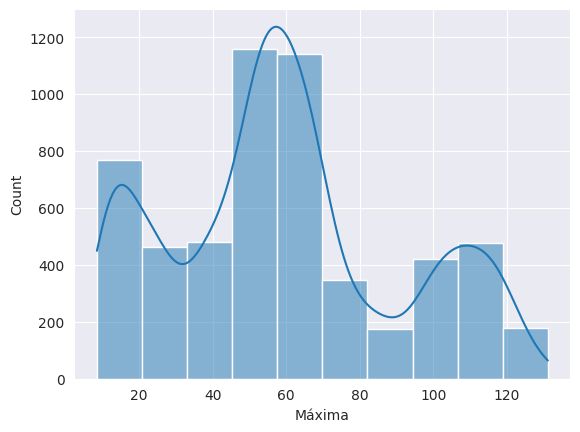

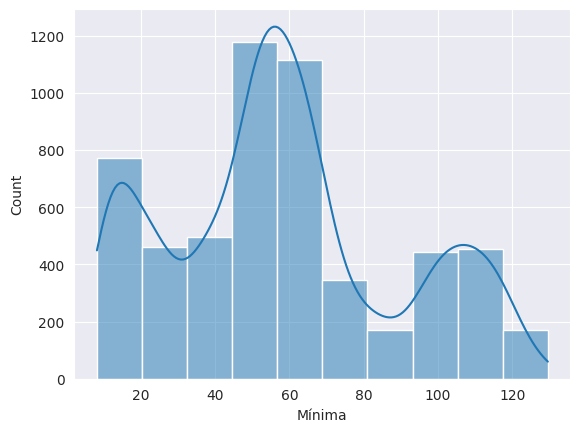

In [ ]:
colunas_numericas_preco = ["Último", "Abertura", "Máxima", "Mínima"]
for column in colunas_numericas_preco:
    plt.figure()
    plot = ibovespa_diario[column]
    sns.histplot(plot, bins=10, kde=True)
    plt.show()

Podemos ver que distribuiçao dos dados de valores ao longo seguem um comportamento similar.

<ipython-input-437-e3f7f1958548>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

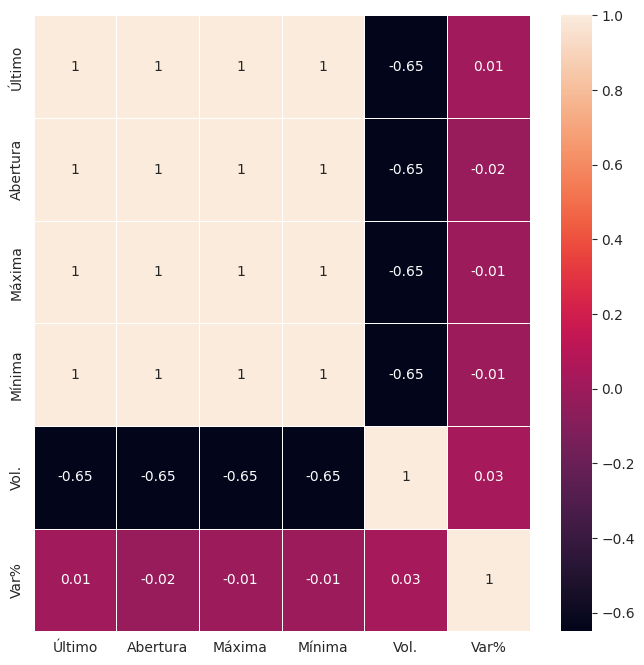

In [ ]:
correlation_matrix = ibovespa_diario.corr().round(2)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

### Distribuições com filtro de datas a partir de 2010 (redução do tempo de análise)

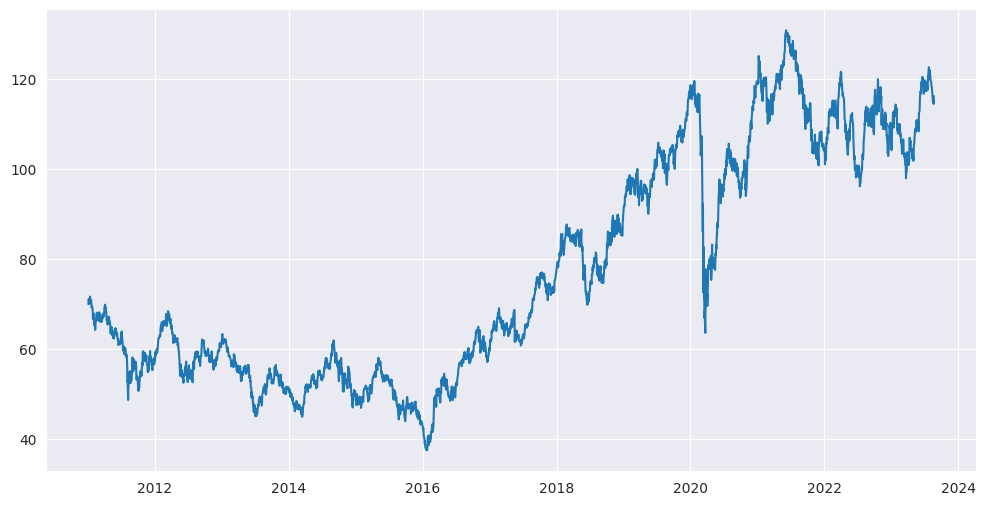

In [ ]:
ibovespa_pos_2010 = ibovespa_diario.loc[ibovespa_diario.index.year > 2010]
ibovespa_pos_2010 = ibovespa_pos_2010.sort_index()
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(ibovespa_pos_2010.index, ibovespa_pos_2010.Último)
plt.show()

> Como as movimentações na bolsa são afetadas por dados extermos, vemos uma queda acentuada logo no começo de 2020, quando ocorreu a pandemia global do Coronavírus.

> O mercado voltou a crescer ao longo de 2021.

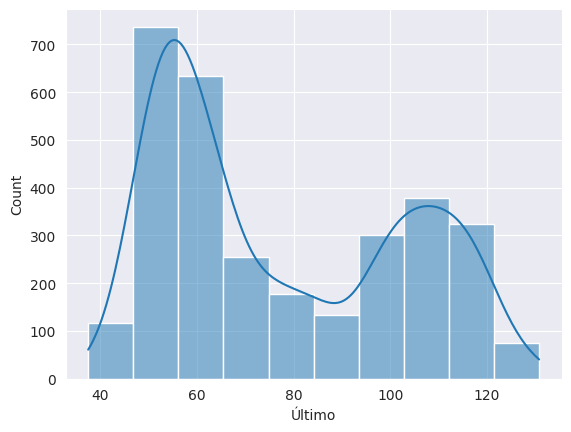

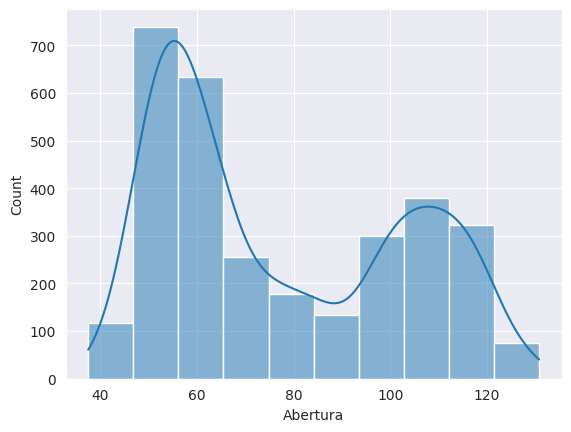

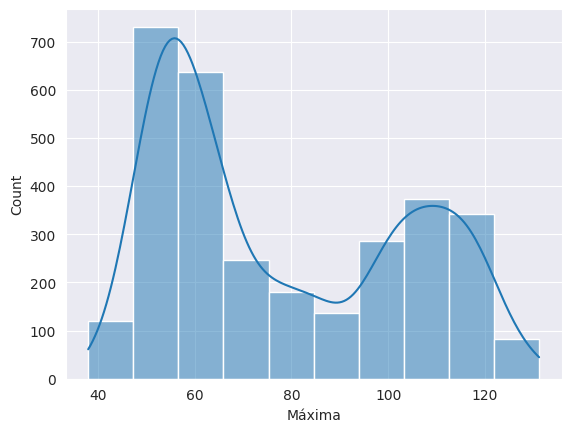

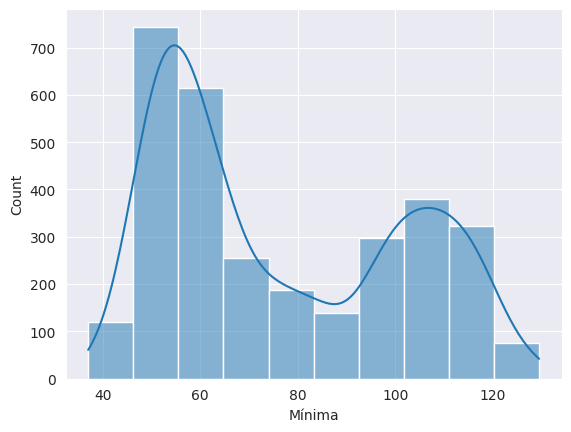

In [ ]:
colunas_numericas_preco = ["Último", "Abertura", "Máxima", "Mínima"]
for column in colunas_numericas_preco:
    plt.figure()
    plot = ibovespa_pos_2010[column]
    sns.histplot(plot, bins=10, kde=True)
    plt.show()

## Análises temporais - Visão e análises

> O **preço de fechamento** reflete o valor final pelo qual o ativo foi negociado durante o dia e é frequentemente usado como um indicador-chave para análise de séries temporais.

* ds = ibovespa_diario.index
* y = ibovespa_diario["Último]
* ticker = ibovespa

In [ ]:
!pip install prophet pandas_ta

In [ ]:
# importação de bibliotecas para modelo e análise de series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas
import plotly.graph_objs as go
import pandas_ta as ta
import math

In [ ]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

### Análise do seasonal Decompose

#### Seasonal decompose a partir de 2010

In [ ]:
dados_decompose = ibovespa_pos_2010[['Último']]
dados_decompose = dados_decompose.dropna()
dados_decompose = dados_decompose.sort_index()

In [ ]:
resultados = seasonal_decompose(dados_decompose, period=5)

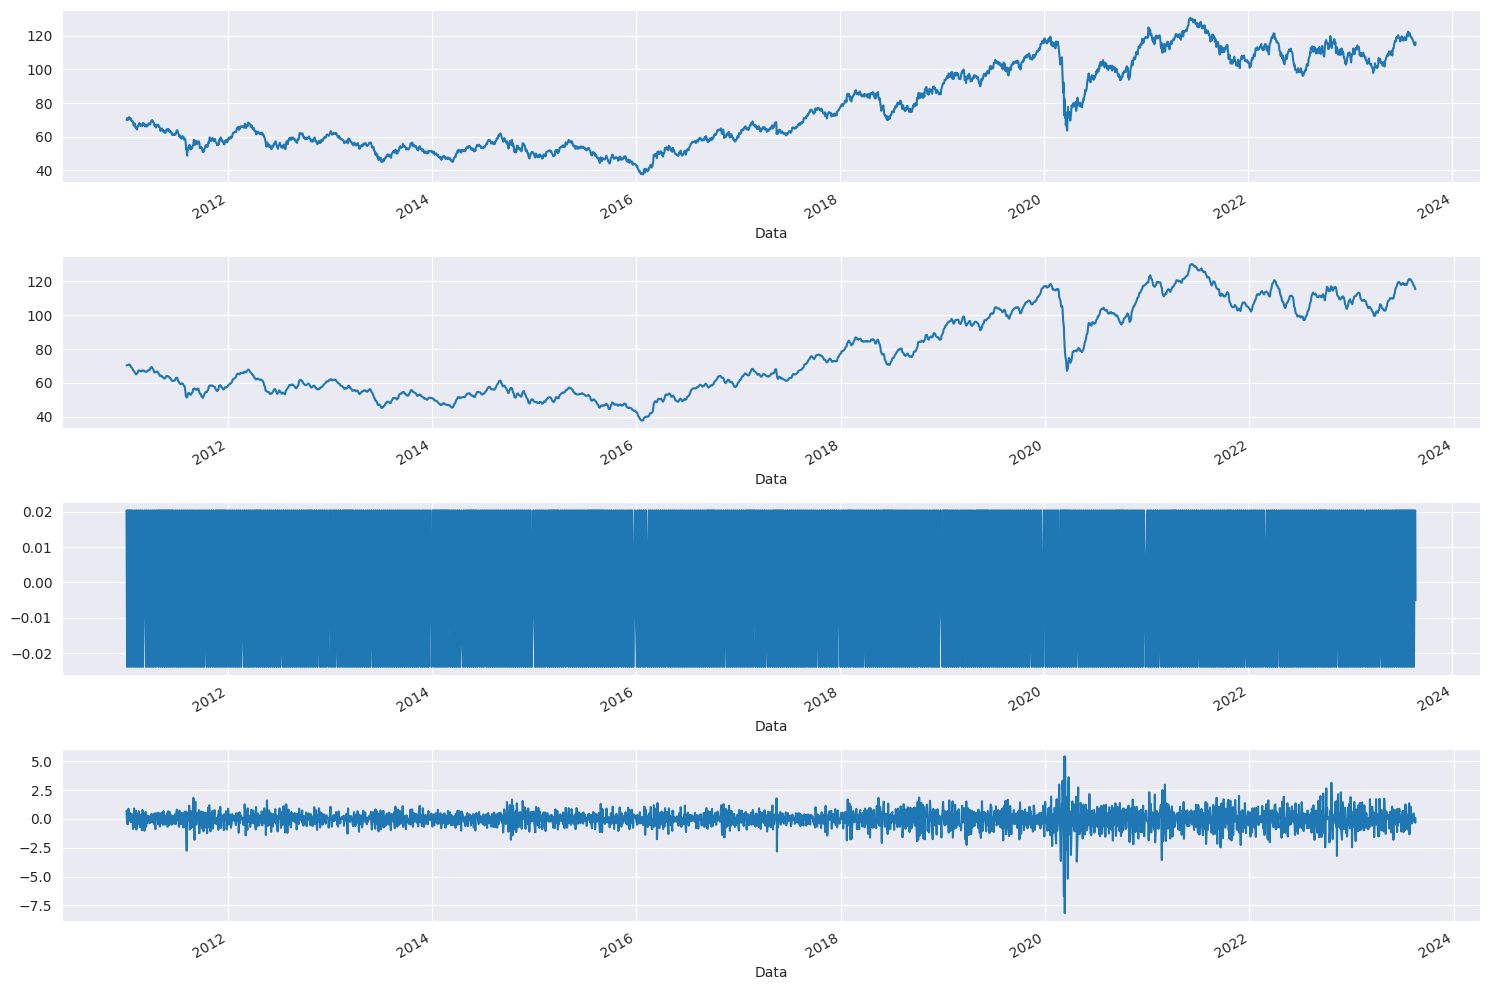

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

> **Inferências iniciais dos gráficos**:

* Pelas análises de obsevração e tendência, temos um comportamento de crescimento ao longo dos anos, indicando que há um aumento no volume das cotações em relação à cotação no momento do fechamento.

* Vemos também que a concentração de resíduo fica maior no final do período analisado


* Analisando os dados de sazonalidade desde 2010, não é possível avaliar se há uma sazonalidade no comportamento dos dados. Vamos reduzir o tempo para ter uma avaliação melhor da situação.

#### Seasonal decompose a partir de 2022

In [ ]:
dados_decompose_2 = ibovespa_pos_2010.loc[ibovespa_pos_2010.index.year > 2021]
dados_decompose_2 = dados_decompose_2[['Último']]
dados_decompose_2 = dados_decompose_2.dropna()
dados_decompose_2 = dados_decompose_2.sort_index()


resultados_2 = seasonal_decompose(dados_decompose_2, period=5)

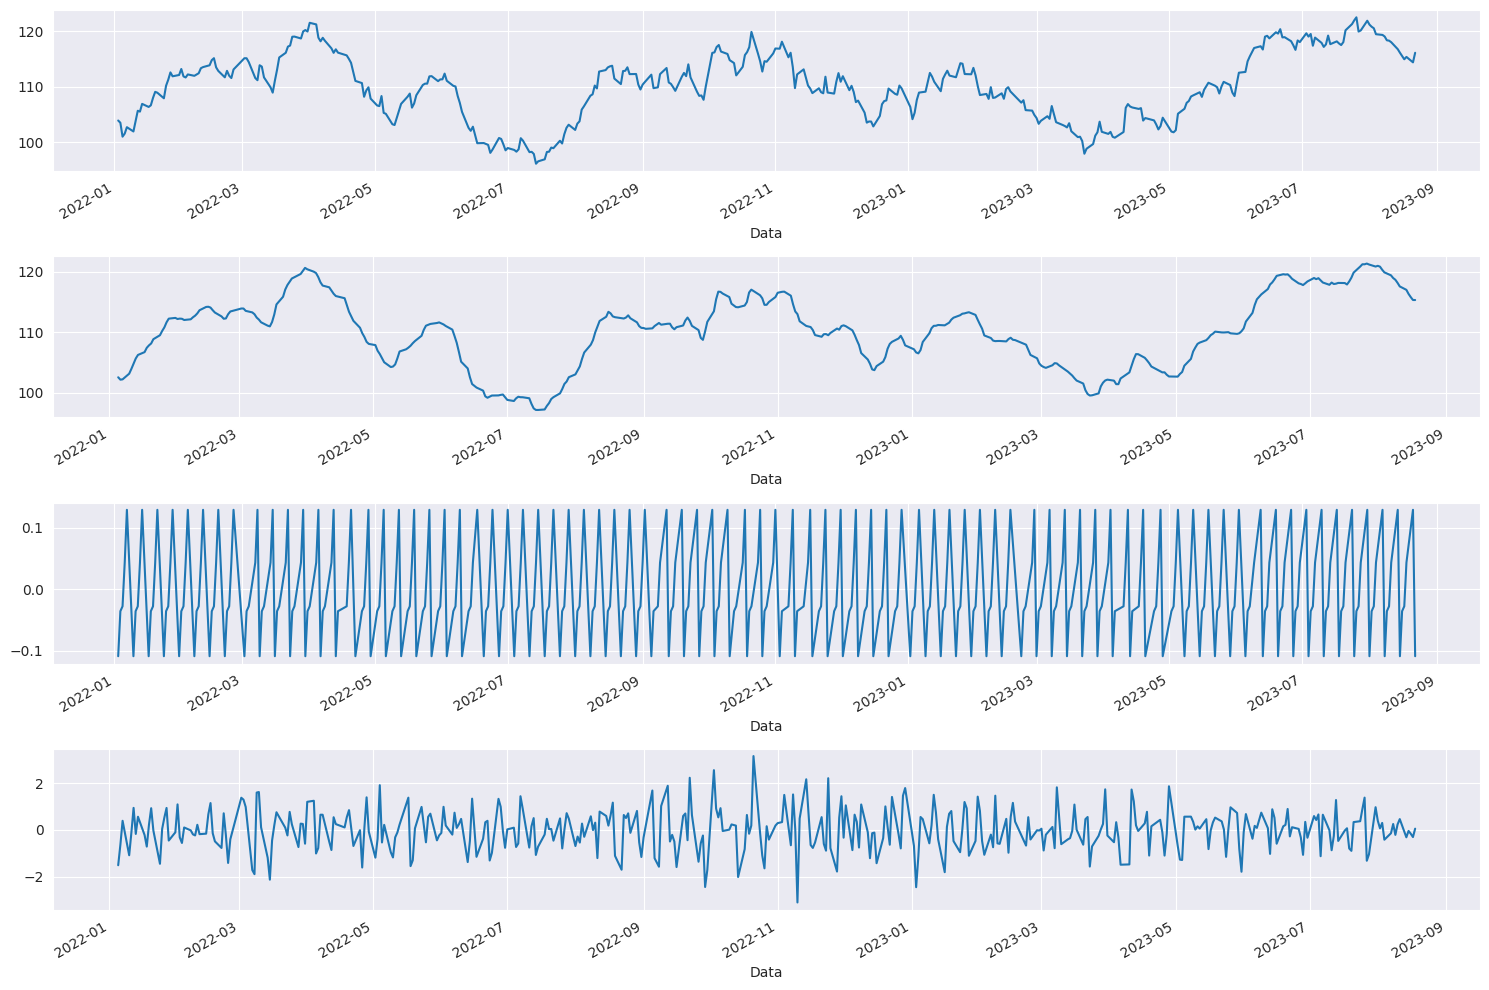

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados_2.observed.plot(ax=ax1)
resultados_2.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados_2.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados_2.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

> **Inferências pós-redução do tempo de análise**:

* Reduzindo o tempo de análises, vemos que não há uma tendência muito bem definida nos dados, que oscila ao longo do tempo.

* O resídio também aparenta uma constância, após um aumento ao final de 2022.

* Podemos também inferir inicialmente que esses dados **não são estacionários,**, com base na tendência do gráfico 2 da tabela acima.

### Análise do AdFuller

    H0 -> Série não estacionária (p-value > 0.05)
    H1 -> Série estacionária (p-value <= 0.05)

#### AdFuller considerando base pós 2010 - NÃO ESTACIONÁRIA (p-value = 0.77)

In [ ]:
X_2011 = dados_decompose.Último.values  # transformação dos dados em variável

# configuração do teste
result_2011 = adfuller(X_2011)

alpha = 0.05

# print das métricas do teste
print("Teste ADF - Dados pós 2011")
print(f"Teste Estatístico: {result_2011[0]}")
print(f"P-Value: {result_2011[1]}")
print("Valores críticos:")

for key, value in result_2011[4].items():
  print(f"\t{key}: {value}")


print("Avaliação do p-value")
if result_2011[1] >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária")
else:
  print(f"\tRejeitar a hipótese nula - Série Estacionária.")


Teste ADF - Dados pós 2011
Teste Estatístico: -0.9294690848934833
P-Value: 0.7781130066362649
Valores críticos:
	1%: -3.4324449684310445
	5%: -2.8624656272139637
	10%: -2.5672627334083655
Avaliação do p-value
	Estatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária


#### AdFuller considerando base pós 2022 - NÃO ESTACIONÁRIA (p-value = 0.10)

In [ ]:
X_2022 = dados_decompose_2.Último.values  # transformação dos dados em variável

# configuração do teste
result_2022 = adfuller(X_2022)

alpha = 0.05

# print das métricas do teste
print("Teste ADF - Dados pós 2022")
print(f"Teste Estatístico: {result_2022[0]}")
print(f"P-Value: {result_2022[1]}")
print("Valores críticos:")

for key, value in result_2022[4].items():
  print(f"\t{key}: {value}")


print("Avaliação do p-value")
if result_2022[1] >= alpha:
  print(f"\tEstatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária")
else:
  print(f"\tRejeitar a hipótese nula - Série Estacionária.")

Teste ADF - Dados pós 2022
Teste Estatístico: -2.5312262750606433
P-Value: 0.10806029484343327
Valores críticos:
	1%: -3.4464400156784927
	5%: -2.868632644097719
	10%: -2.5705481612974577
Avaliação do p-value
	Estatisticamente, não podemos rejeitar a hipótese nula - Série Não Estacionária


# Criação dos modelos

## Construção dos modelos com Prophet

### 1️⃣ Análise 1: Modelo sem separação de bases de treino / teste (Dados entre Jan/2022 a Agosto/2023)

In [ ]:
# configuração do df para modelo (usando todos os dados a partir de 2022 e sem separação de bases entre treino e validação)
dados_modelo = dados_decompose_2.reset_index()
dados_modelo = dados_modelo.rename(columns={"Data": "ds", "Último": "y"})
dados_modelo.ta.ema(close='y', length=21, append=True) # adicionado o cálculo da média movel exponencial, considerando 21 dias (aplica mais peso aos dados mais atuais).
dados_modelo.dropna(inplace=True)
dados_modelo.head()

,ds,y,EMA_21
20,2022-01-31,112.144,106.751667
21,2022-02-01,113.228,107.340424
22,2022-02-02,111.894,107.754386
23,2022-02-03,111.696,108.112714
24,2022-02-04,112.245,108.488377


In [ ]:
dados_modelo.shape

(391, 3)

In [ ]:
# configuração do modelo e fit dos dados de treino
model = Prophet(daily_seasonality=True)
model.fit(dados_modelo)

future = model.make_future_dataframe(periods=30) # validação para 30D posteriores
forecast = model.predict(future) #

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/9wd5cy0t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/_ou47ypp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96929', 'data', 'file=/tmp/tmpx92d36nj/9wd5cy0t.json', 'init=/tmp/tmpx92d36nj/_ou47ypp.json', 'output', 'file=/tmp/tmpx92d36nj/prophet_model38onj64b/prophet_model-20230829203429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:34:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
plot_plotly(model,forecast)

> A linha indica uma previsão que, aparentemente, acompanha a tendência dos de movimentação os dados atuais.

> Porém, é possível perceber que há um volume considerável de outliers dentro desta visão (pontos pretos fora dos intervalos de confiança).

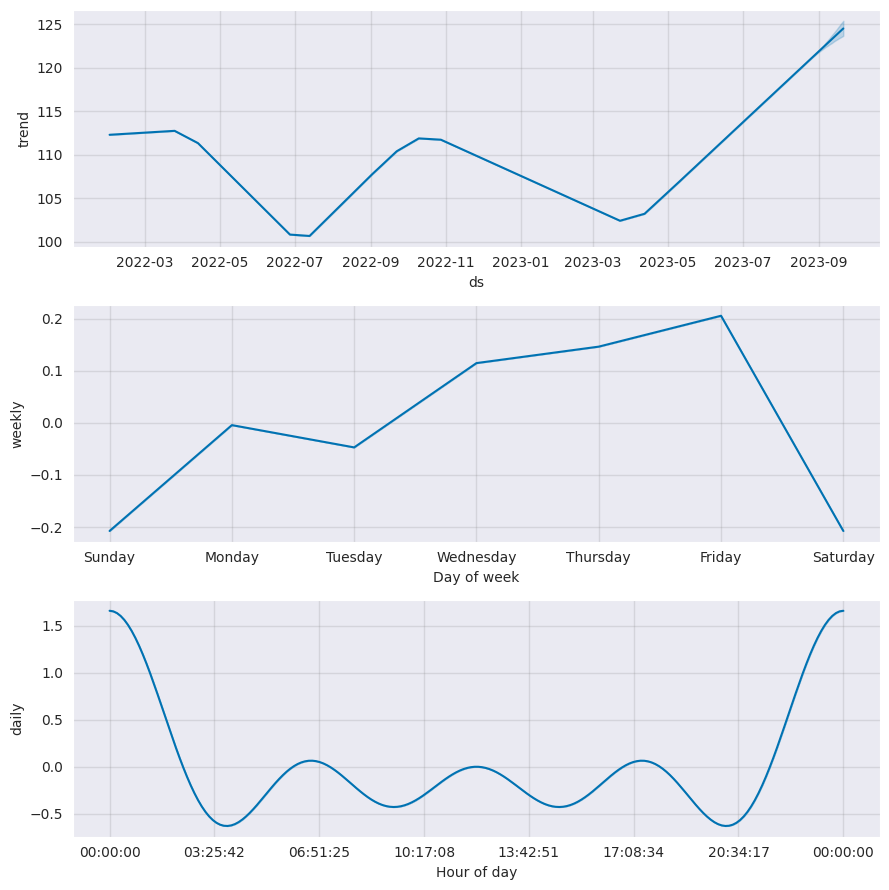

In [ ]:
model.plot_components(forecast)
plt.show()

In [ ]:
fig = go.Figure([
    go.Scatter(x=dados_modelo['ds'], y=dados_modelo['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=forecast['ds'], y=dados_modelo['EMA_21'], name='EMA', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Para uma visão melhor, há uma visão acima unindo as previsões, os dados reais e a média móvel exponencial dos últimos 21 dias.

* A predição, apesar de seguir uma sazonalidade similar, tem diferenças em relação ao mvoimento e intensidade dos dados.

* Nos últimos dias, vemos que os dados preditos seguem em um movimento crescente enquanto tanto a predição quando os dados móveis apresentam comportamento de queda

In [ ]:
# Acessar predições do modelo
pred_df = forecast[forecast['ds'] > '2023-08-22'][['ds','yhat']]

# ajustar dataframe
pred_df.reset_index(inplace=True)
pred_df.drop(labels='index', axis=1,inplace=True)
pred_df.rename(columns={'ds': 'ds', 'yhat': 'y_pred'}, inplace=True)
pred_df.head()

,ds,y_pred
0,2023-08-23,122.470011
1,2023-08-24,122.633327
2,2023-08-25,122.824302
3,2023-08-26,122.543335
4,2023-08-27,122.675087


### 📊 Análise 1: Relatório com métricas de performance

In [ ]:
uniao_dados = forecast.set_index('ds')[['yhat']].join(dados_modelo.set_index('ds').y).reset_index().dropna()

wmape_forecast_v1 = wmape(uniao_dados['y'].values, uniao_dados['yhat'].values)
print(f'WMape V1: {wmape_forecast_v1:.2%}')

mse_forecast_v1 = mean_squared_error(uniao_dados['y'].values, uniao_dados['yhat'].values)
print(f'MSE V1: {mse_forecast_v1:.2%}')

mae_forecast_v1 = mean_absolute_error(uniao_dados['y'].values, uniao_dados['yhat'].values)
print(f'MAE V1: {mae_forecast_v1:.2%}')

rmse_forecast_v1 = math.sqrt(mean_absolute_error(uniao_dados['y'].values, uniao_dados['yhat'].values))
print(f'RMSE V1: {rmse_forecast_v1:.2%}')

WMape: 2.53%
MSE: 1117.18%
MAE: 278.68%
RMSE: 166.94%


**Inferências Modelo 1:**

> Apesar do WMape relativamente baixo, as outras margens de erro MSE, MAE e RMSE indicam uma grande dispersão entre os dados previstos e os reais.

#### Validação Cruzada

In [ ]:
# execute cross validation
df_cv = cross_validation(model, initial='421 days', period='7 days', horizon = '30 days')

# measure performance
df_p = performance_metrics(df_cv)

In [ ]:
print(df_cv.tail()) # visualize data
print(df_p) # measure performance

            ds        yhat  yhat_lower  yhat_upper        y     cutoff
356 2023-08-16  125.077603  121.249375  129.209482  115.592 2023-07-23
357 2023-08-17  125.338284  121.147833  129.500089  114.982 2023-07-23
358 2023-08-18  125.536786  121.377373  129.626845  115.409 2023-07-23
359 2023-08-21  125.860017  121.459114  129.971465  114.429 2023-07-23
360 2023-08-22  125.979798  122.107982  130.311542  116.156 2023-07-23
   horizon         mse       rmse       mae      mape     mdape     smape  \
0   3 days   25.735974   5.073064  4.083905  0.036258  0.037542  0.037241   
1   4 days   26.273968   5.125814  4.040158  0.035862  0.023834  0.036847   
2   5 days   30.858063   5.555003  4.486845  0.039756  0.029862  0.040941   
3   8 days   36.929710   6.076982  4.952291  0.043798  0.043574  0.045252   
4   9 days   38.148313   6.176432  5.011053  0.044354  0.044248  0.045869   
5  10 days   38.520398   6.206480  4.967706  0.043840  0.040115  0.045346   
6  11 days   38.777647   6.227170  

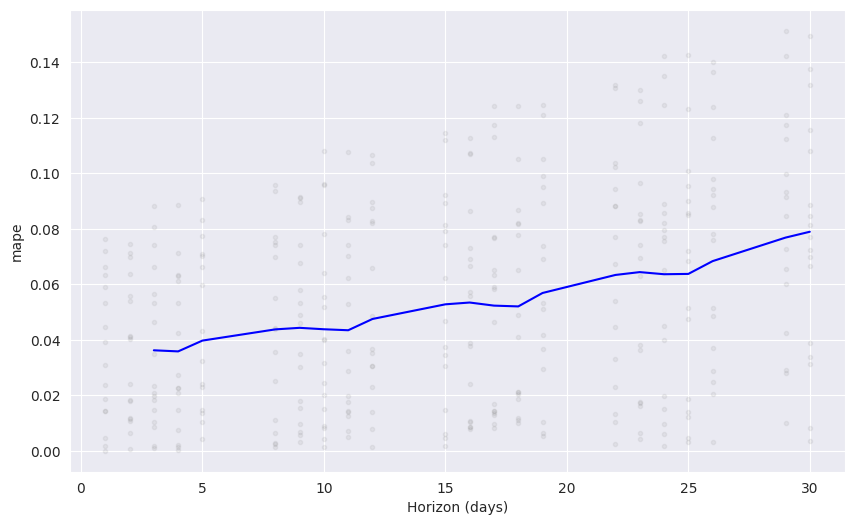

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### 2️⃣ Análise 2: Modelo com separação das bases de treino vs teste (Dados entre Jan/2022 a Agosto/2023)

In [ ]:
print(dados_modelo["ds"].min())
print(dados_modelo["ds"].max())

2022-01-31 00:00:00
2023-08-22 00:00:00


In [ ]:
periodo_base = int(len(dados_modelo) * 0.2) # determinando o período
print("Período (20% dos dados):", periodo_base)
train, validation = dados_modelo.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:]

Período (20% dos dados): 78


In [ ]:
print("Dados base treino:")
print(train["ds"].min())
print(train["ds"].max())
print(len(train))

print("Dados base valid:")
print(validation["ds"].min())
print(validation["ds"].max())
print(len(validation))

Dados base treino:
2022-01-31 00:00:00
2023-05-03 00:00:00
313
Dados base valid:
2023-05-04 00:00:00
2023-08-22 00:00:00
78


In [ ]:
#fit do modelo
model = Prophet()
model.fit(train)

#predições
future = model.make_future_dataframe(periods=(len(validation)+1), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast = model.predict(future)
forecast_valid = forecast['yhat'][-periodo:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/a90tmlzh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/3tbpyjyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99777', 'data', 'file=/tmp/tmpx92d36nj/a90tmlzh.json', 'init=/tmp/tmpx92d36nj/3tbpyjyi.json', 'output', 'file=/tmp/tmpx92d36nj/prophet_modelfow59iau/prophet_model-20230829211819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
plot_plotly(model,forecast)

> A partir da separação dos dados, vemos uma tedência um pouco mais alinhada com os dados atuais do que o modelo anteior (sem separação das bases).

> Mas analisando o gráfico abaixo, vemos que a predição está em uma direção constrária aos dados reais.

<ipython-input-528-777bc19d27c4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-528-777bc19d27c4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



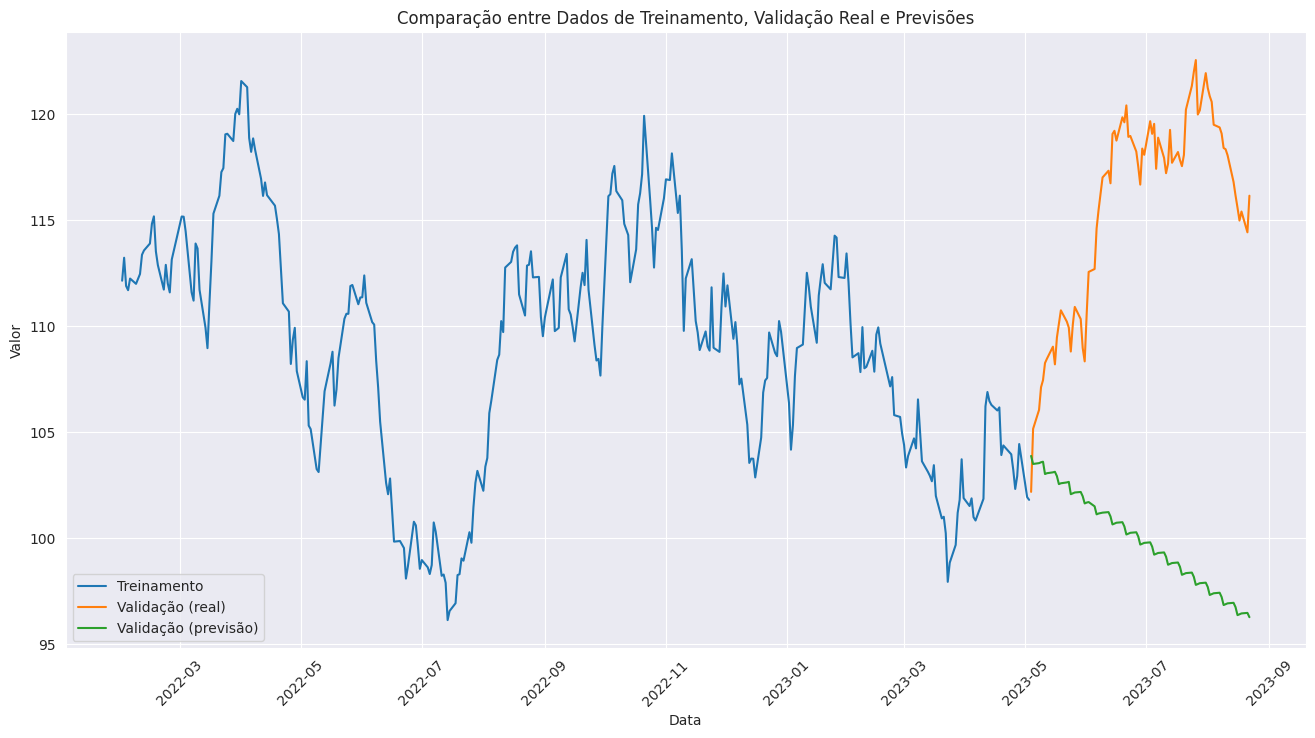

In [ ]:
validation['yhat'] = 0
validation['yhat'] = forecast_valid.values


plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Treinamento')  # Usando "ds" no eixo x para o treinamento
plt.plot(validation['ds'], validation['y'], label='Validação (real)')  # Usando "ds" no eixo x para a validação real
plt.plot(validation['ds'], validation['yhat'], label='Validação (previsão)')  # Usando "ds" no eixo x para as previsões
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor')  # Adiciona rótulo ao eixo y
plt.title('Comparação entre Dados de Treinamento, Validação Real e Previsões')
plt.show()

Na análise dos componentes abaixo, vemos que o tamanho das bandas de intervalo são bem grandes, demonstrando um nível de erro mais acentuado.

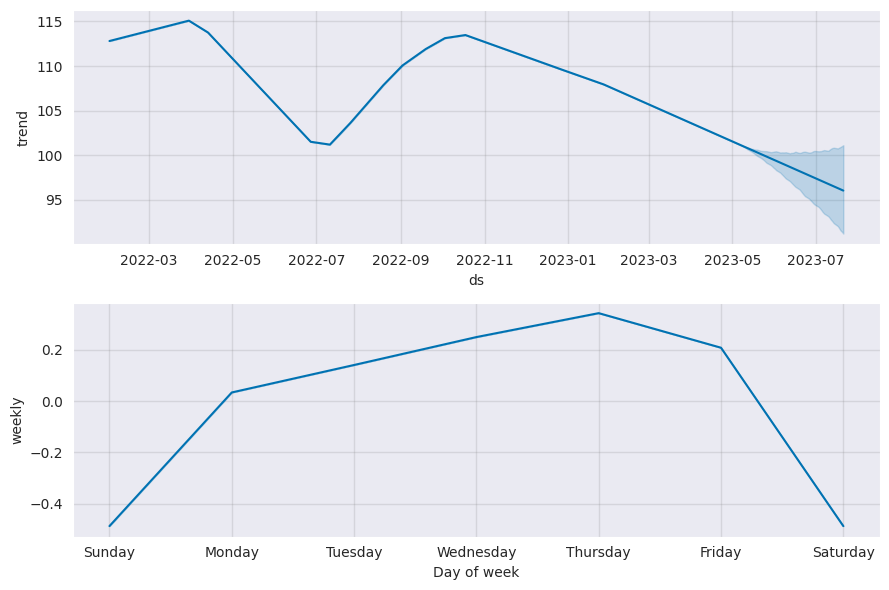

In [ ]:
model.plot_components(forecast)
plt.show()

In [ ]:
# train = train[['ds','y']]
# dados_forecast = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
# df = pd.merge(train, dados_forecast, on='ds', how='right')
# df.set_index('ds').plot(figsize=(16,8), title= 'Fechamento dados',color=['#F29F0E', "#000000", "#0EB6F2", "#0EB6F2"], grid=True);

### 📊 Análise 2: Relatório com métricas de performance

In [ ]:
validacao_2 = forecast.set_index('ds')[['yhat']].join(validation.set_index('ds').y).reset_index().dropna()

wmape_forecast_v2 = wmape(validacao_2['y'].values, validacao_2['yhat'].values)
print(f'WMape V2: {wmape_forecast_v2:.2%}')

mse_forecast_v2 = mean_squared_error(validacao_2['y'].values, validacao_2['yhat'].values)
print(f'MSE V2: {mse_forecast_v2:.2%}')

mae_forecast_v2 = mean_absolute_error(validacao_2['y'].values, validacao_2['yhat'].values)
print(f'MAE V2: {mae_forecast_v2:.2%}')

rmse_forecast_v2 = math.sqrt(mean_absolute_error(validacao_2['y'].values, validacao_2['yhat'].values))
print(f'RMSE V2: {rmse_forecast_v2:.2%}')

WMape: 13.60%
MSE: 28221.55%
MAE: 1555.75%
RMSE: 394.43%


**Inferências Modelo 2:**

* Temos um WMape de 13%, maior do que o modelo anterior, já indicando uma acurácia menor.
* Todos as outras métricas de erro também aumentaram entre um teste e outro.
* No modelo, excluimos datas de final da semana (sábado e domingo) da precisão futura, entretanto ao rodar o código sem essa validação os valores de erro aumentam.

### 3️⃣ Análise 3: Modelo com separação das bases de treino vs teste (30 últimos dias de dado - 12/07 a 22/08/23)

In [ ]:
# Separação das bases entre treino e validação
periodo_base = int(len(dados_30D) * 0.2)
train, validation = dados_30D.iloc[:-periodo_base], dados_30D.iloc[-periodo_base:]

print("Dados base treino:")
print(train["ds"].min())
print(train["ds"].max())
print("Tamanho base treino:", len(train))

print("Dados base valid:")
print(validation["ds"].min())
print(validation["ds"].max())
print("Tamanho base valid:",len(validation))

Dados base treino:
2023-07-12 00:00:00
2023-08-14 00:00:00
Tamanho base treino: 24
Dados base valid:
2023-08-15 00:00:00
2023-08-22 00:00:00
Tamanho base valid: 6


In [ ]:
#fit do modelo
model = Prophet()
model.fit(train)

#predições
future = model.make_future_dataframe(periods=(len(validation)+1), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast = model.predict(future)
forecast_valid = forecast['yhat'][-periodo_base:]

<ipython-input-574-777bc19d27c4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-574-777bc19d27c4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



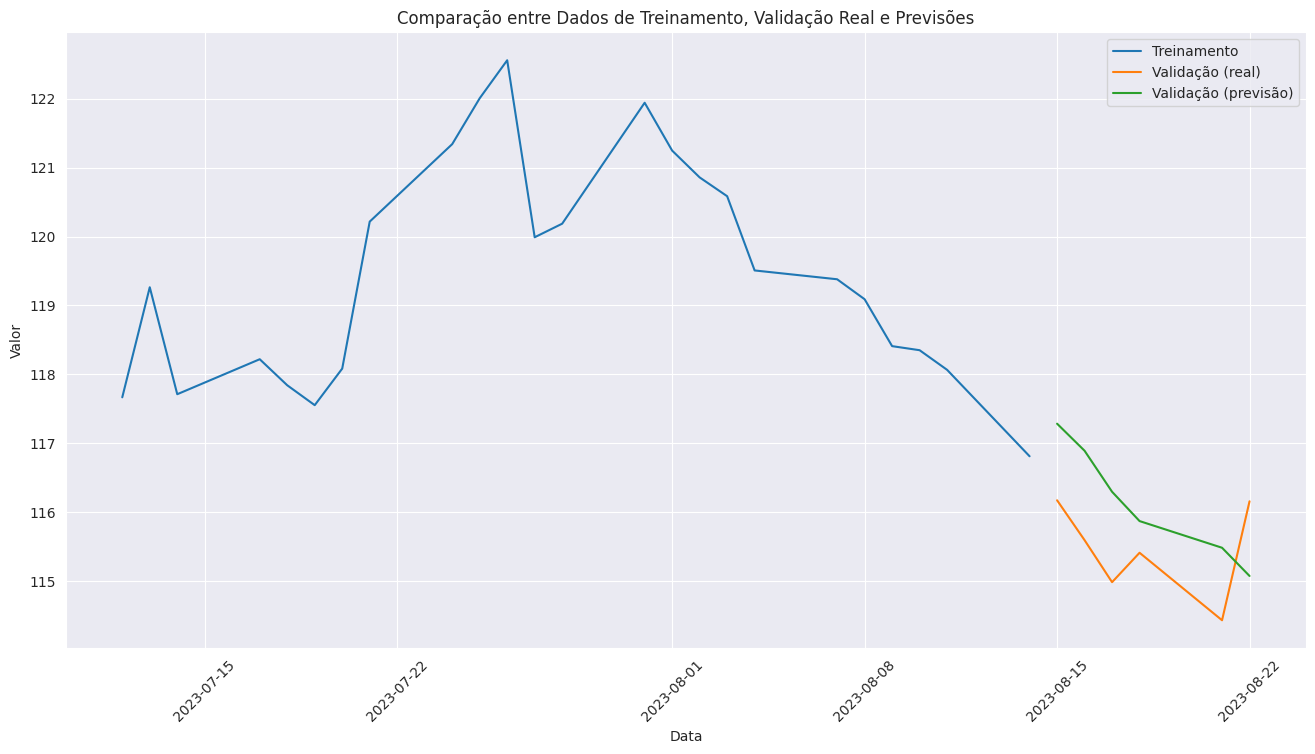

In [ ]:
validation['yhat'] = 0
validation['yhat'] = forecast_valid.values


plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Treinamento')  # Usando "ds" no eixo x para o treinamento
plt.plot(validation['ds'], validation['y'], label='Validação (real)')  # Usando "ds" no eixo x para a validação real
plt.plot(validation['ds'], validation['yhat'], label='Validação (previsão)')  # Usando "ds" no eixo x para as previsões
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor')  # Adiciona rótulo ao eixo y
plt.title('Comparação entre Dados de Treinamento, Validação Real e Previsões')
plt.show()

In [ ]:
plot_plotly(model,forecast)

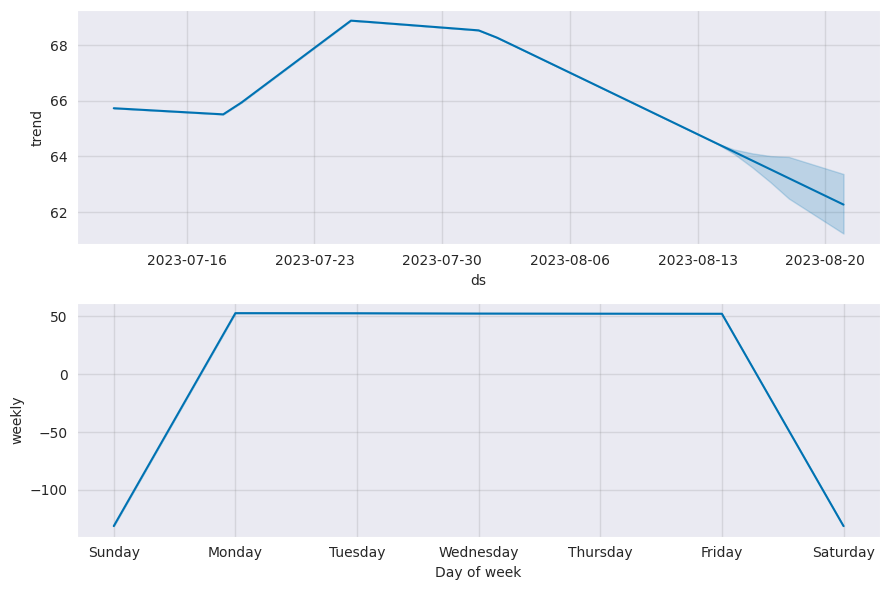

In [ ]:
model.plot_components(forecast)
plt.show()

#### Modelo V1 (não será usado)

In [ ]:
# # Treinamento do modelo
# model = Prophet()
# model.fit(train)


# future = model.make_future_dataframe(periods=30) # validação para 6D posteriores
# forecast = model.predict(future) #

# # Previsão do conjunto de teste
# forecast_valid = model.predict(validation)

In [ ]:
# # Plotagem dos dados
# plt.plot(train["ds"], train["y"], label="Dados de treino")
# plt.plot(validation["ds"], validation["y"], label="Dados de teste")
# plt.plot(forecast_valid["ds"], forecast_valid["yhat"], label="Previsão")
# plt.fill_between(forecast_valid["ds"], forecast_valid["yhat_lower"], forecast_valid["yhat_upper"], color="gray", alpha=0.2)
# plt.title("Previsão com Prophet")
# plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
# plt.legend()
# plt.show()

In [ ]:
# # Avaliação das previsões - Modelo 1

# wmape_forecast_v3 = wmape(validation["y"].values, forecast_valid["yhat"].values)
# print(f'WMape: {wmape_forecast_v3:.2%}')

# mse_forecast_v3 = mean_squared_error(validation["y"].values, forecast_valid["yhat"].values)
# print(f'MSE: {mse_forecast_v3:.2%}')

# mae_forecast_v3 = mean_absolute_error(validation["y"].values, forecast_valid["yhat"].values)
# print(f'MAE: {mae_forecast_v3:.2%}')

# rmse_forecast_v3 = math.sqrt(mean_absolute_error(validation["y"].values, forecast_valid["yhat"].values))
# print(f'RMSE: {rmse_forecast_v3:.2%}')

WMape: 0.65%
MSE: 73.30%
MAE: 75.02%
RMSE: 86.61%


### 📊 Análise 3: Relatórios de Performance

In [ ]:
# Avaliação das previsões

validacao_3 = forecast.set_index('ds')[['yhat']].join(validation.set_index('ds').y).reset_index().dropna()

wmape_forecast_v3 = wmape(validacao_3['y'].values, validacao_3['yhat'].values)
print(f'WMape: {wmape_forecast_v3:.2%}')

mse_forecast_v3 = mean_squared_error(validacao_3['y'].values, validacao_3['yhat'].values)
print(f'MSE: {mse_forecast_v3:.2%}')

mae_forecast_v3 = mean_absolute_error(validacao_3['y'].values, validacao_3['yhat'].values)
print(f'MAE: {mae_forecast_v3:.2%}')

rmse_forecast_v3 = math.sqrt(mean_absolute_error(validacao_3['y'].values, validacao_3['yhat'].values))
print(f'RMSE: {rmse_forecast_v3:.2%}')

WMape: 0.52%
MSE: 44.32%
MAE: 60.49%
RMSE: 77.77%


#### Cross Validation

In [ ]:
# Definição dos parametros para o cross validation com o tamanho das bases de treino e teste
# period: comprimento da sazonalidade (diária)
print("Initial:",len(train)) # ponto inicial do modelo
print("Horizon:",len(validation)) #  período de previsão


Initial: 24
Horizon: 6


In [ ]:
results = cross_validation(model, initial="24 days", period='1 days', horizon = '6 days') # execute cross validation
metrics = performance_metrics(results) # mensuração da performance

In [ ]:
print(metrics)
print(results.tail())

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.770658  0.877871  0.664111  0.005569  0.002867  0.005543   
1  2 days  1.052804  1.026062  0.878600  0.007379  0.007521  0.007343   
2  3 days  1.159855  1.076966  0.849355  0.007159  0.007120  0.007121   
3  4 days  1.542421  1.241943  1.017513  0.008595  0.011631  0.008541   
4  5 days  1.969396  1.403352  1.403100  0.011870  0.011870  0.011800   
5  6 days  1.313070  1.145892  1.096332  0.009321  0.009321  0.009273   

   coverage  
0  0.666667  
1  0.500000  
2  0.500000  
3  0.333333  
4  0.000000  
5  0.500000  
           ds        yhat  yhat_lower  yhat_upper        y     cutoff
13 2023-08-11  118.041830  117.128441  119.121105  118.065 2023-08-07
14 2023-08-09  118.589223  117.729207  119.445408  118.409 2023-08-08
15 2023-08-10  118.095055  117.108924  119.039524  118.350 2023-08-08
16 2023-08-11  117.704581  116.512160  118.779484  118.065 2023-08-08
17 2023-08-14  117.572978  116.107476  1

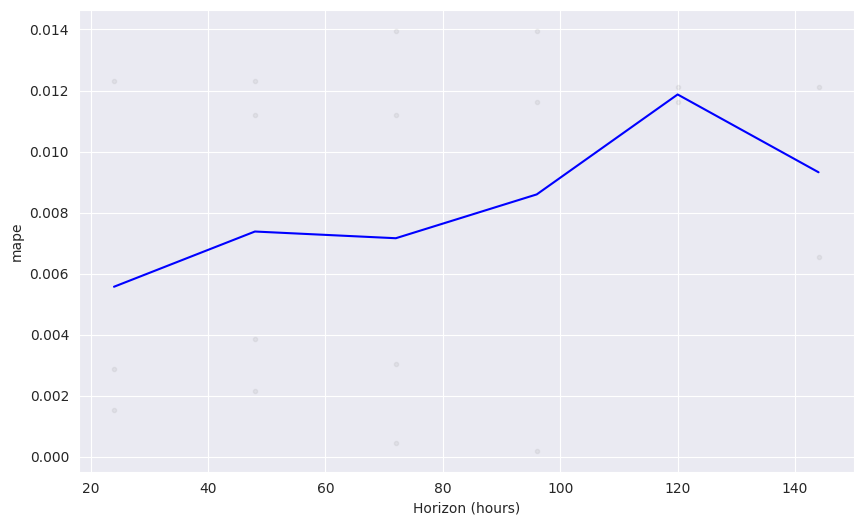

In [ ]:
fig = plot_cross_validation_metric(results, metric='mape')

### 4️⃣ Análise 4: Modelo com separação de bases dos últimos 30 com ajustes nos hiperparâmetros

In [ ]:
dados_decompose = dados_30D.set_index('ds')
dados_decompose = dados_decompose["y"]
dados_decompose.sort_index(inplace=True)

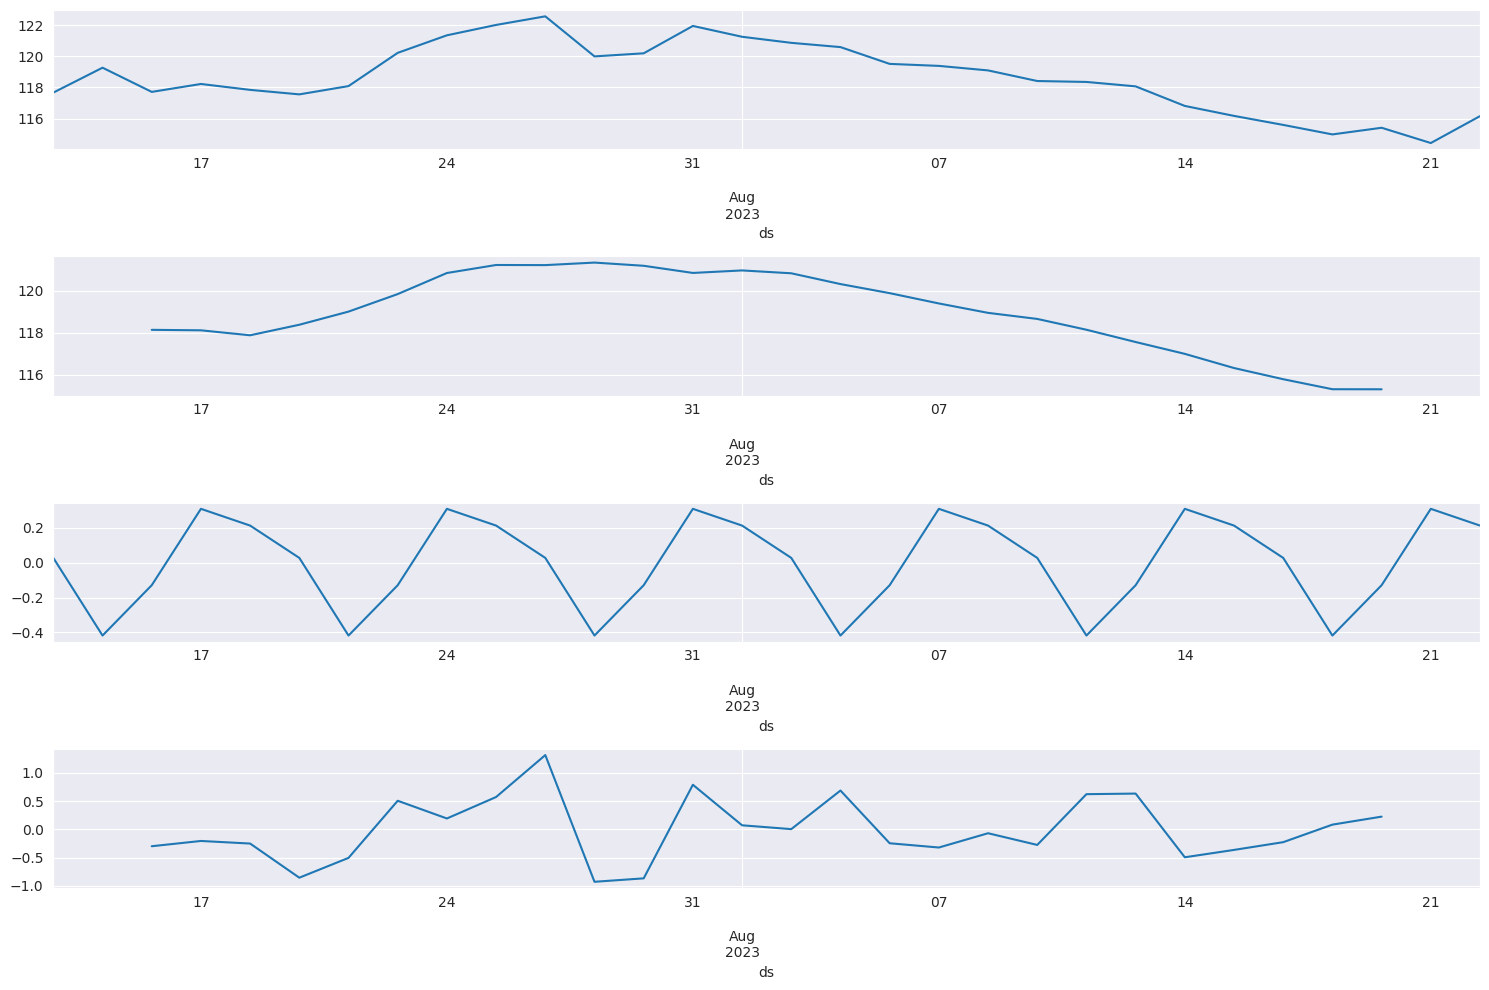

In [ ]:
resultados_30d = seasonal_decompose(dados_decompose)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,10))

resultados_30d.observed.plot(ax=ax1)
resultados_30d.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultados_30d.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultados_30d.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

** Inclusão de Hiperparâmetros no modelo Prophet**:

* seasonality_mode: se refere aos componentes de sazonalidade - "additive" ou "multiplicative"
> Vamos usar o Multiplicativo ao invés de "aditivo", para aumentar a importância das sazonalidades ao longo do tempo.

* growth: Crescimento da tendência - "linear" ou "logistic"

In [ ]:
# Separação das bases entre treino e validação
dados_30D.sort_index()
periodo_base = int(len(dados_30D) * 0.2)
train, validation = dados_30D.iloc[:-periodo_base], dados_30D.iloc[-periodo_base:]


#fit do modelo
model_adj = Prophet(seasonality_mode="multiplicative", growth="linear") # ajuste de hiperametros
model_adj.fit(train)

#predições
future = model_adj.make_future_dataframe(periods=(len(validation)+1), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast_adj = model_adj.predict(future)
forecast_valid_adj = forecast_adj['yhat'][-periodo_base:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/gvxa7rvf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/86hdv68w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41753', 'data', 'file=/tmp/tmpx92d36nj/gvxa7rvf.json', 'init=/tmp/tmpx92d36nj/86hdv68w.json', 'output', 'file=/tmp/tmpx92d36nj/prophet_model0qlgg4po/prophet_model-20230829220231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:

<ipython-input-628-c0bf46a3da44>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-628-c0bf46a3da44>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



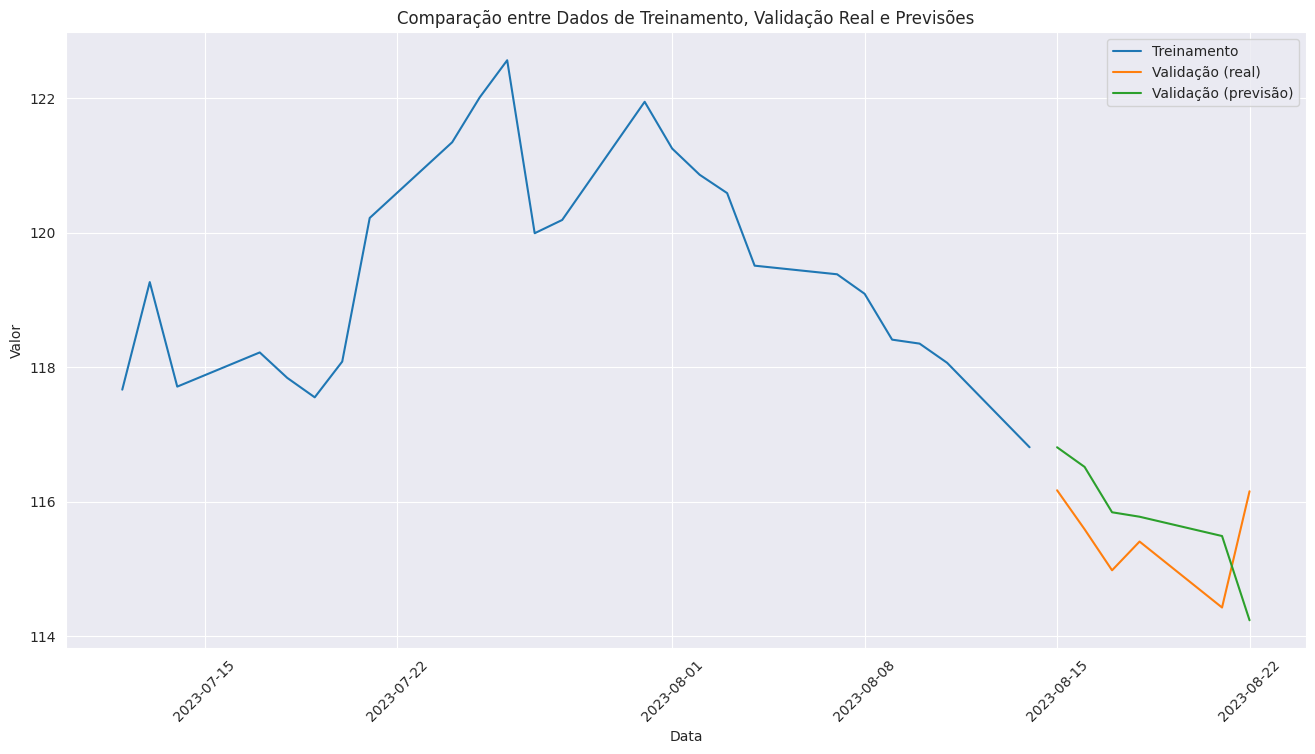

In [ ]:
validation['yhat'] = 0
validation['yhat'] = forecast_valid_adj.values


plt.figure(figsize=(16, 8))
plt.plot(train['ds'], train['y'], label='Treinamento')  # Usando "ds" no eixo x para o treinamento
plt.plot(validation['ds'], validation['y'], label='Validação (real)')  # Usando "ds" no eixo x para a validação real
plt.plot(validation['ds'], validation['yhat'], label='Validação (previsão)')  # Usando "ds" no eixo x para as previsões
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.xlabel('Data')  # Adiciona rótulo ao eixo x
plt.ylabel('Valor')  # Adiciona rótulo ao eixo y
plt.title('Comparação entre Dados de Treinamento, Validação Real e Previsões')
plt.show()

In [ ]:
plot_plotly(model_adj,forecast_adj)

In [ ]:
fig = go.Figure([
    go.Scatter(x=train['ds'], y=train['y'], name='Train', mode='lines'),
    go.Scatter(x=validation["ds"], y=validation["y"], name='Validated', mode='lines'),
    go.Scatter(x=validation['ds'], y=validation['yhat'], name='Predicted', mode='lines')])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"), dict(count=1, label="1m", step="month", stepmode="backward"),dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"), dict(count=1, label="1y", step="year", stepmode="backward"), dict(step="all")])))
fig.show()

#### Modelo não usado

In [ ]:
# # Separação das bases entre treino e validação
# periodo_base = int(len(dados_30D) * 0.2)
# train, validation = dados_30D.iloc[:-periodo_base], dados_30D.iloc[-periodo_base:]


# # Treinamento do modelo
# model_adj = Prophet(seasonality_mode="multiplicative", growth="linear") # ajuste de hiperametros
# model_adj.fit(train)


# # Previsão do conjunto de teste
# forecast_adj = model_adj.predict(validation)

In [ ]:
# # Plotagem dos dados
# plt.plot(train['ds'], train['y'], label='Treinamento')
# plt.plot(validation["ds"], validation["y"], label="Dados de teste")
# plt.plot(validation['ds'], validation['yhat'], label="Previsão")
# plt.fill_between(forecast_adj["ds"], forecast_adj["yhat_lower"], forecast_adj["yhat_upper"], color="gray", alpha=0.2)
# plt.title("Previsão com Prophet - Ajustes de Hiperparametros")
# plt.legend()
# plt.show()

In [ ]:
# # Avaliação das previsões
# wmape_forecast_v4 = wmape(validation["y"].values, forecast_adj["yhat"].values)
# print(f'WMape Adj: {wmape_forecast_v4:.2%}')

# mse_forecast_v4 = mean_squared_error(validation["y"].values, forecast_adj["yhat"].values)
# print(f'MSE Adj: {mse_forecast_v4:.2%}')

# mae_forecast_v4 = mean_absolute_error(validation["y"].values, forecast_adj["yhat"].values)
# print(f'MAE Adj: {mae_forecast_v4:.2%}')

# rmse_forecast_v4 = math.sqrt(mean_absolute_error(validation["y"].values, forecast_adj["yhat"].values))
# print(f'RMSE: {rmse_forecast_v4:.2%}')

### 📊 Análise 4: Relatórios de performance

In [ ]:
# Avaliação das previsões

validacao_4 = forecast_adj.set_index('ds')[['yhat']].join(validation.set_index('ds').y).reset_index().dropna()

wmape_forecast_v4 = wmape(validacao_4['y'].values, validacao_4['yhat'].values)
print(f'WMape: {wmape_forecast_v4:.2%}')

mse_forecast_v4 = mean_squared_error(validacao_4['y'].values, validacao_4['yhat'].values)
print(f'MSE: {mse_forecast_v4:.2%}')

mae_forecast_v4 = mean_absolute_error(validacao_4['y'].values, validacao_4['yhat'].values)
print(f'MAE: {mae_forecast_v4:.2%}')

rmse_forecast_v4 = math.sqrt(mean_absolute_error(validacao_4['y'].values, validacao_4['yhat'].values))
print(f'RMSE: {rmse_forecast_v4:.2%}')

WMape: 0.29%
MSE: 17.21%
MAE: 33.34%
RMSE: 57.74%


#### Cross validation

In [ ]:
results_adj = cross_validation(model_adj, initial="24 days", period='1 days', horizon = '6 days') # execute cross validation
metrics_adj = performance_metrics(results_adj) # mensuração da performance

In [ ]:
print(results_adj.tail())

           ds        yhat  yhat_lower  yhat_upper        y     cutoff
13 2023-08-11  117.068479  110.180868  123.685914  118.065 2023-08-07
14 2023-08-09  118.705676  117.045221  120.341929  118.409 2023-08-08
15 2023-08-10  118.432209  113.105230  123.372238  118.350 2023-08-08
16 2023-08-11  117.368311  107.342816  127.708703  118.065 2023-08-08
17 2023-08-14  117.226254  101.057578  133.788936  116.810 2023-08-08


In [ ]:
print(metrics_adj)

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.762739  0.873349  0.681909  0.005721  0.002506  0.005746   
1  2 days  1.390056  1.179006  0.848344  0.007117  0.006435  0.007166   
2  3 days  1.609110  1.268507  1.084823  0.009144  0.009577  0.009201   
3  4 days  2.223785  1.491236  1.453011  0.012282  0.013253  0.012362   
4  5 days  4.907348  2.215254  2.181036  0.018455  0.018455  0.018632   
5  6 days  3.386236  1.840173  1.492573  0.012661  0.012661  0.012777   

   coverage  
0  0.666667  
1  0.750000  
2  1.000000  
3  1.000000  
4  1.000000  
5  1.000000  


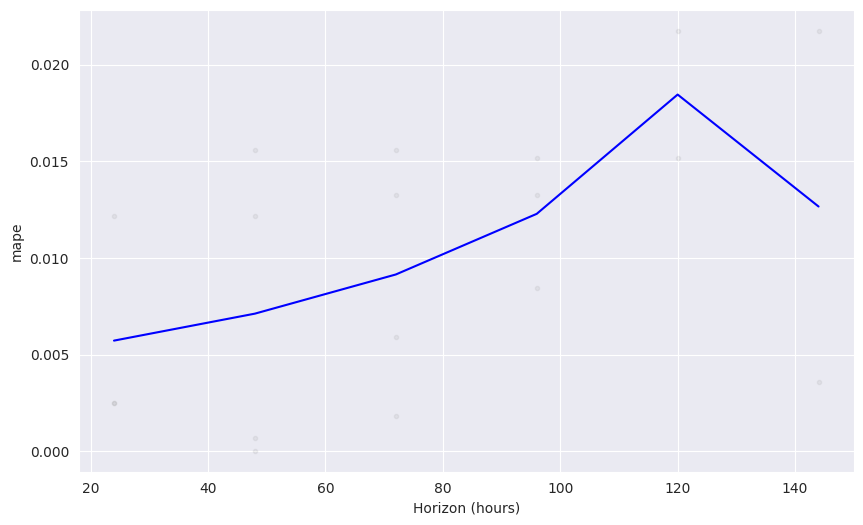

In [ ]:
fig = plot_cross_validation_metric(results_adj, metric='mape')


> No h1, o modelo apresentou baixo erro médio quadrado (MSE) e baixo erro absoluto médio (MAE), indicando que as previsões estão próximas dos valores reais.

> Pela análise da métrica de "coverage" tivemos uma cobertura dos intervalos de confiança foi relativamente alta (próxima de 1.0), o que significa que os intervalos capturaram bem os valores reais.



> A partir do dia 4, os valores de erro MSE e MAE aumentam mais, indicando que o modelo pode ter mais dificuldade em fazer previsões precisas para períodos mais distantes no futuro.


#### **O modelo parece ser mais eficiente em prever valores para um horizonte de previsão mais curto (1 ou 2 dias), com métricas mais baixas de erro médio e absoluto.**

### 🛠️ Validação de previsão dos dados entre 23 a 28/08
Entendimento se a previsão acerta os próximos dias pós uso.

In [ ]:
dados_futuro = pd.read_csv("ibov-12.07a29.08.csv", sep=",", parse_dates=[0], index_col="Data",dayfirst=True) # definição da coluna Data como index
dados_futuro.sort_index(inplace=True)
dados_futuro.index.name='ds'
dados_futuro = dados_futuro[["Último"]]
dados_futuro.columns = ["y"]
dados_futuro.reset_index(inplace=True)
dados_futuro

In [ ]:
dados_futuro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      35 non-null     datetime64[ns]
 1   y       35 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 688.0 bytes


In [ ]:
# Separação das bases entre treino e validação
period_data = int(len(dados_futuro) * 0.2)
train_data, test_data = dados_futuro.iloc[:-period_data], dados_futuro.iloc[-period_data:]

# # Separação das bases entre treino e validação
# train_data = dados_futuro.loc[dados_futuro["ds"] < '2023-08-23']
# test_data = dados_futuro.loc[dados_futuro["ds"] >= '2023-08-22']

In [ ]:
# Treinamento do modelo
model_adj = Prophet(seasonality_mode="multiplicative", growth="linear") # ajuste de hiperametros
model_adj.fit(train_data)

# # Previsão do conjunto de teste
# forecast_adj = model_adj.predict(test_data)


#predições
future = model_adj.make_future_dataframe(periods=int(len(test_data)), freq='d')
validation_week = future['ds'].map(lambda x : True if x.weekday() in range(0, 5) else False)
future = future[validation_week]
forecast_future = model_adj.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/f_xj9he6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx92d36nj/2n61c1c0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35042', 'data', 'file=/tmp/tmpx92d36nj/f_xj9he6.json', 'init=/tmp/tmpx92d36nj/2n61c1c0.json', 'output', 'file=/tmp/tmpx92d36nj/prophet_modelws371uem/prophet_model-20230829175005.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [ ]:
fig = go.Figure([
    go.Scatter(x=train_data["ds"], y=train_data["y"], name='Train', mode='lines'),
    go.Scatter(x=test_data["ds"], y=test_data["y"], name='Validated', mode='lines'),
    go.Scatter(x=forecast_future["ds"], y=forecast_future["yhat"], name='Predicted', mode='lines')
])
fig.show()

In [ ]:
# # Plotagem dos dados
# plt.plot(train_data["ds"], train_data["y"], label="Dados de treino")
# plt.plot(test_data["ds"], test_data["y"], label="Dados de teste")
# plt.plot(forecast_adj["ds"], forecast_adj["yhat"], label="Previsão")
# plt.fill_between(forecast_adj["ds"], forecast_adj["yhat_lower"], forecast_adj["yhat_upper"], color="gray", alpha=0.2)
# plt.title("Previsão com Prophet - Real vs Futuro")
# plt.legend()
# plt.show()

In [ ]:
# fig = go.Figure([
#     go.Scatter(x=train_data["ds"], y=train_data["y"], name='Train', mode='lines'),
#     go.Scatter(x=test_data["ds"], y=test_data["y"], name='Validated', mode='lines'),
#     go.Scatter(x=forecast_adj["ds"], y=forecast_adj["yhat"], name='Predicted', mode='lines')
# ])
# fig.show()

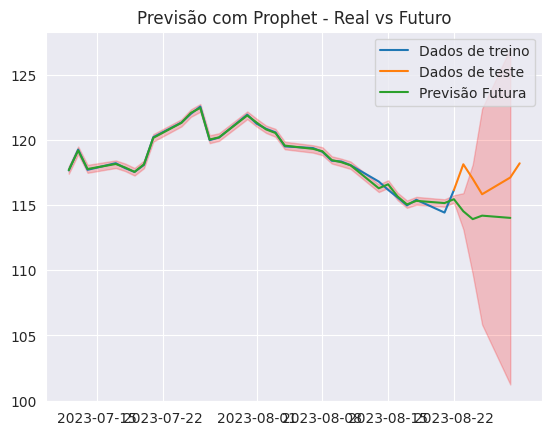

In [ ]:
# Plotagem dos dados
plt.plot(train_data["ds"], train_data["y"], label="Dados de treino")
plt.plot(test_data["ds"], test_data["y"], label="Dados de teste")
# plt.plot(forecast_adj["ds"], forecast_adj["yhat"], label="Previsão")
plt.plot(forecast_future["ds"], forecast_future["yhat"], label="Previsão Futura")
# plt.fill_between(forecast_adj["ds"], forecast_adj["yhat_lower"], forecast_adj["yhat_upper"], color="gray", alpha=0.2)
plt.fill_between(forecast_future["ds"], forecast_future["yhat_lower"], forecast_future["yhat_upper"], color="red", alpha=0.2)
plt.title("Previsão com Prophet - Real vs Futuro")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score #avaliação do modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report #métricas de avaliação

PRÓXIMAS VALIDAÇÕES:
- Ao invés de prever o valor final, considerar as oscilações se o mercado está dubindo ou descendo (deve comprar ou vender ações?)

### ❌ Construção do modelo com prophet previsão diária (NÃO FUNCIONOU)

tentando validar o que levantaram no grupo


```
# Acho que estou chegando perto da solução, acredito que o problema é que estamos tentando prever todo o período de teste com base
no comportamento da curva do período de treino, quando na verdade a cada nova predição de um dia o modelo deveria ser
"atualizado" com os valores da própria previsão feita
```



In [ ]:
# selecionar os últimos 30 dias da base de dados (reduzir o tempo para tentar melhorar a precisão)
select = 30
dados_30D = dados_modelo.iloc[-select:]
print(dados_30D["ds"].min())
print(dados_30D["ds"].max())

2023-07-12 00:00:00
2023-08-22 00:00:00


In [ ]:
# Separação das bases entre treino e validação

periodo_base = int(len(dados_30D) * 0.2) # determinando o período limite para bases de teste e treino
print("Período (80% dos dados):", periodo_base)
train, validation = dados_30D.iloc[:-periodo_base], dados_modelo.iloc[-periodo_base:] # divisão dos períodos

Período (80% dos dados): 6


In [ ]:
# Treinamento inicial do modelo com prophet com base de treino
init_model = Prophet()
init_model.fit(train)

# Previsão iterativa para o conjunto de teste (a c)
previsao = []
for index, row in validation.iterrows():
    forecast = init_model.predict(pd.DataFrame({'ds': [row['ds']]}))
    predicted_value = forecast['yhat'].iloc[0]
    previsao.append(predicted_value)

    # Atualizar o modelo com o valor previsto
    new_data = pd.DataFrame({'ds': [row['ds']], 'y': [predicted_value]})
    init_model = Prophet()
    init_model.fit(pd.concat([train, new_data]))

validation['predictions'] = previsao

In [ ]:
# Plot dos dados reais
plt.figure(figsize=(10, 6))
plt.plot(validation['ds'], validation['y'], label='Real')
plt.plot(validation['ds'], validation['predictions'], label='Previsões')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsões vs. Valores Reais')
plt.legend()
plt.show()

In [ ]:
plot_plotly(init_model,forecast)

In [ ]:
# Avaliação das previsões
wmape_forecast_v2 = wmape(validation['y'].values, validation['predictions'].values)
print(f'WMape: {wmape_forecast_v2:.2%}')

mse_forecast_v2 = mean_squared_error(validation['y'].values, validation['predictions'].values)
print(f'MSE: {mse_forecast_v2:.2%}')

mae_forecast_v2 = mean_absolute_error(validation['y'].values, validation['predictions'].values)
print(f'MAE: {mae_forecast_v2:.2%}')

rmse_forecast_v2 = math.sqrt(mean_absolute_error(validation['y'].values, validation['predictions'].values))
print(f'RMSE: {rmse_forecast_v2:.2%}')



WMape: 0.68%
MSE: 75.71%
MAE: 78.31%
RMSE: 88.49%
